## Backtest simulation for only investing in SPY ** 

In [77]:
!pip install TA-Lib

     -------------------------------------- 272.6/272.6 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build TA-Lib


  error: subprocess-exited-with-error
  
  × Building wheel for TA-Lib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [26 lines of output]
      <string>:77: UserWarning: Cannot find ta-lib library, installation may fail.
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\talib
      copying talib\abstract.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\deprecated.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\stream.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\test_abstract.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\test_data.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\test_func.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\test_pandas.py -> build\lib.win-amd64-cpython-310\talib
      copying talib\test_polars.py -> build\lib.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from math import floor
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)
    

# Backtesting Class

In [27]:
class BacktestingSystem:
    def __init__(self, investment_cash=5):
        self.data = None
        self.investment_cash = investment_cash
    
    # Download data from yfinance
    def load_data(self, symbol, start_date, end_date):
        print(symbol)
        self.data = yf.download(symbol,start_date, end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
        self.data.columns = ['open', 'high', 'low', 'close', 'volume']
    
    # Visualize Results
    def plot_results(self, portfolio):
        plt.style.use('fivethirtyeight')

    
        fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    
        # Plot stock price
        ax[0].plot(self.data['close'], label='Price', color='steelblue', linewidth=2)
        ax[0].set_ylabel('Price', fontsize=12)
        ax[0].legend(loc='upper left', fontsize=10)
    
        # Plot portfolio value
        ax[1].plot(portfolio['total'], label='Portfolio Value', color='forestgreen', linewidth=2)
        ax[1].set_ylabel('Portfolio Value', fontsize=12)
        ax[1].legend(loc='upper left', fontsize=10)
    
        # Set x-axis label for the last subplot
        ax[1].set_xlabel('Date', fontsize=12)
    
        # Adjust spacing between subplots
        plt.tight_layout(pad=2)
    
        # Set title and axis labels
        fig.suptitle('Backtesting Results', fontsize=16, fontweight='bold')
    
        # Customize tick parameters
        plt.tick_params(axis='both', which='both', bottom=False, left=False)
    
        # Remove spines
        for axis in ['top', 'right']:
            ax[0].spines[axis].set_visible(False)
            ax[1].spines[axis].set_visible(False)
    
        # Display the plot
        plt.show()

    def plot_indicator(self, portfolio):

        plt.style.use('fivethirtyeight')
        plt.rcParams['figure.figsize'] = (20,8)

        plt.plot(portfolio['close'], linewidth = 2)
        plt.plot(portfolio['st'], color = 'green', linewidth = 2, label = 'ST UPTREND')
        plt.plot(portfolio['st_dt'], color = 'r', linewidth = 2, label = 'ST DOWNTREND')
        plt.title('SPY ST TRADING direction')
        plt.legend(loc = 'upper left')
        plt.show()

    def backtest_strategy(self, strategy):
        signals = strategy.generate_signals()
        positions = signals['signal']
        portfolio = pd.DataFrame(index=signals.index)
        portfolio['position'] = positions
        portfolio['close'] = signals['close']
        
        portfolio['Investment'] = self.investment_cash

        # portfolio['total'] = (portfolio['position'] * portfolio['close']).cumsum()

        portfolio['total'] = (portfolio['position'] * portfolio['Investment']).cumsum()

        Total_money_invested = portfolio['total'].iloc[-1]

        portfolio_spy_avg = portfolio[portfolio['position']==1]['close'].mean()

        portfolio_total_shares = portfolio['total'].iloc[-1]/ portfolio[portfolio['position']==1]['close'].mean()


        # Calculate portfolio value

        print("\n")
        print('Total money invested: $', int(Total_money_invested  )  )
        print("\n")
        print('Total Portfolio value : $', int(portfolio_total_shares * portfolio['close'].iloc[-1] ) )
        print("\n")
        print('Portfolio up %  : ', int(100 - (int(Total_money_invested)/int(portfolio_total_shares * portfolio['close'].iloc[-1] ))*100 ))
        print("\n")
        print('The average SPY price of the portfolio is: ', portfolio_spy_avg )
        print("\n")
        print('No. of shares: ', portfolio_total_shares  )
        print("\n")
        print('Profit till the date : $', (portfolio_total_shares * portfolio['close'].iloc[-1]) - Total_money_invested )
        print("\n")

        return portfolio

## TODO : Invet 5$ every day for 1 

- Wait 3 days for confirmation 

- Wait Condition that last Extreme greed price is greater than Extreme fear

- Super trend indicator? for bearish signal confirmation?

- How close is fear_index number to the category (Multiplier 2 * 1.5 * 1 * 0.5)


In [44]:
# Moving Average Crossover Strategy

class FearandGreedIndexStrategy:
    def __init__(self, data,fear_data):
        self.data = data
        self.fear_data = fear_data

    def fear_category(self,x):
        if x <= 25:
            return "Extreme fear"
        elif (x <= 50) and (x > 25):
            return "Fear"
        elif (x <= 75) and (x > 50):
            return "Greed"
        elif (x <= 100) and (x > 75):
            return "Extreme Greed"
    
    # SUPERTREND CALCULATION
    def get_supertrend(self,high, low, close, lookback, multiplier):
        
        # ATR
        
        tr1 = pd.DataFrame(high - low)
        tr2 = pd.DataFrame(abs(high - close.shift(1)))
        tr3 = pd.DataFrame(abs(low - close.shift(1)))
        frames = [tr1, tr2, tr3]
        tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
        atr = tr.ewm(lookback).mean()
        
        # H/L AVG AND BASIC UPPER & LOWER BAND
        
        hl_avg = (high + low) / 2
        upper_band = (hl_avg + multiplier * atr).dropna()
        lower_band = (hl_avg - multiplier * atr).dropna()
        
        # FINAL UPPER BAND
        
        final_bands = pd.DataFrame(columns = ['upper', 'lower'])
        final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
        final_bands.iloc[:,1] = final_bands.iloc[:,0]
        
        for i in range(len(final_bands)):
            if i == 0:
                final_bands.iloc[i,0] = 0
            else:
                if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                    final_bands.iloc[i,0] = upper_band[i]
                else:
                    final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
        
        # FINAL LOWER BAND
        
        for i in range(len(final_bands)):
            if i == 0:
                final_bands.iloc[i, 1] = 0
            else:
                if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                    final_bands.iloc[i,1] = lower_band[i]
                else:
                    final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
        
        # SUPERTREND
        
        supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
        supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
        
        for i in range(len(supertrend)):
            if i == 0:
                supertrend.iloc[i, 0] = 0
            elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
                supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
            elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
                supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
            elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
                supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
            elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
                supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        
        supertrend = supertrend.set_index(upper_band.index)
        supertrend = supertrend.dropna()[1:]
        
        # ST UPTREND/DOWNTREND
        
        upt = []
        dt = []
        close = close.iloc[len(close) - len(supertrend):]

        for i in range(len(supertrend)):
            if close[i] > supertrend.iloc[i, 0]:
                upt.append(supertrend.iloc[i, 0])
                dt.append(np.nan)
            elif close[i] < supertrend.iloc[i, 0]:
                upt.append(np.nan)
                dt.append(supertrend.iloc[i, 0])
            else:
                upt.append(np.nan)
                dt.append(np.nan)
                
        st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
        upt.index, dt.index = supertrend.index, supertrend.index
        
        return st, upt, dt

    # SUPERTREND STRATEGY

    def implement_st_strategy(self,prices, st):
        buy_price = []
        sell_price = []
        st_signal = []
        signal = 0
        
        for i in range(len(st)):
            if st[i-1] > prices[i-1] and st[i] < prices[i]:
                if signal != 1:
                    buy_price.append(prices[i])
                    sell_price.append(np.nan)
                    signal = 1
                    st_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    st_signal.append(0)
            elif st[i-1] < prices[i-1] and st[i] > prices[i]:
                if signal != -1:
                    buy_price.append(np.nan)
                    sell_price.append(prices[i])
                    signal = -1
                    st_signal.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    st_signal.append(0)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
                
        return buy_price, sell_price, st_signal
        
    def Previous_fear_index_check(self,test):
        # Initialize a new column to track the strategy signal
        test['strategy_signal'] = 0

        # Initialize variables to track the previous fear_index and SPY value
        previous_fear_index = None
        previous_spy_value = None

        # Iterate over the DataFrame rows
        for i in range(len(test)):
            current_fear_index = test.loc[i, 'signal']
            current_spy_value = test.loc[i, 'close']

            # Check if current fear_index is 'Fear' or 'Extreme fear'
            if current_fear_index in ['Extreme fear']:
                # Check if previous fear_index exists and current SPY value is less than the previous SPY value
                if previous_fear_index is not None and current_spy_value < previous_spy_value:
                    # Set strategy signal to 1
                    test.loc[i, 'strategy_signal'] = 1

            # Update previous fear_index and SPY value
            previous_fear_index = current_fear_index
            previous_spy_value = current_spy_value

        return test

    def generate_signals(self):

        Complete_df = pd.merge(self.fear_data, self.data, on='Date', how='inner')
        Complete_df.dropna(inplace=True)

        Complete_df.set_index('Date',inplace=True)

        Complete_df['signal'] = 0

        # Fear indicator

        # Complete_df['signal'] = Complete_df['Fear_index'].apply(lambda x: self.fear_category(x))

        # Super Trend indicator

        Complete_df['st'], Complete_df['s_upt'], Complete_df['st_dt'] = self.get_supertrend(Complete_df['high'], Complete_df['low'], Complete_df['close'], 10, 3)

        Complete_df = Complete_df[1:]

        Complete_df.loc[(Complete_df['st_dt'].fillna(0) != 0) & (Complete_df['Fear_index'] <= 40), 'signal'] = 1 

        # Generate trading signals

        # Complete_df['signal'].replace(['Greed', 'Fear', 'Extreme fear', 'Extreme Greed'],[0,0,1,0], inplace=True)
        

        # # Find indices where three consecutive 1's occur
        # indices = Complete_df['signal'].rolling(window=3).sum() == 3
        # # Replace three consecutive 1's with 0
        # Complete_df.loc[indices, 'signal'] = 0
        

        return Complete_df

SPY
[*********************100%***********************]  1 of 1 completed


Total money invested: $ 4800


Total Portfolio value : $ 4932


Portfolio up %  :  2


The average SPY price of the portfolio is:  408.92807388305664


No. of shares:  11.738005548067804


Profit till the date : $ 132.07508521540967




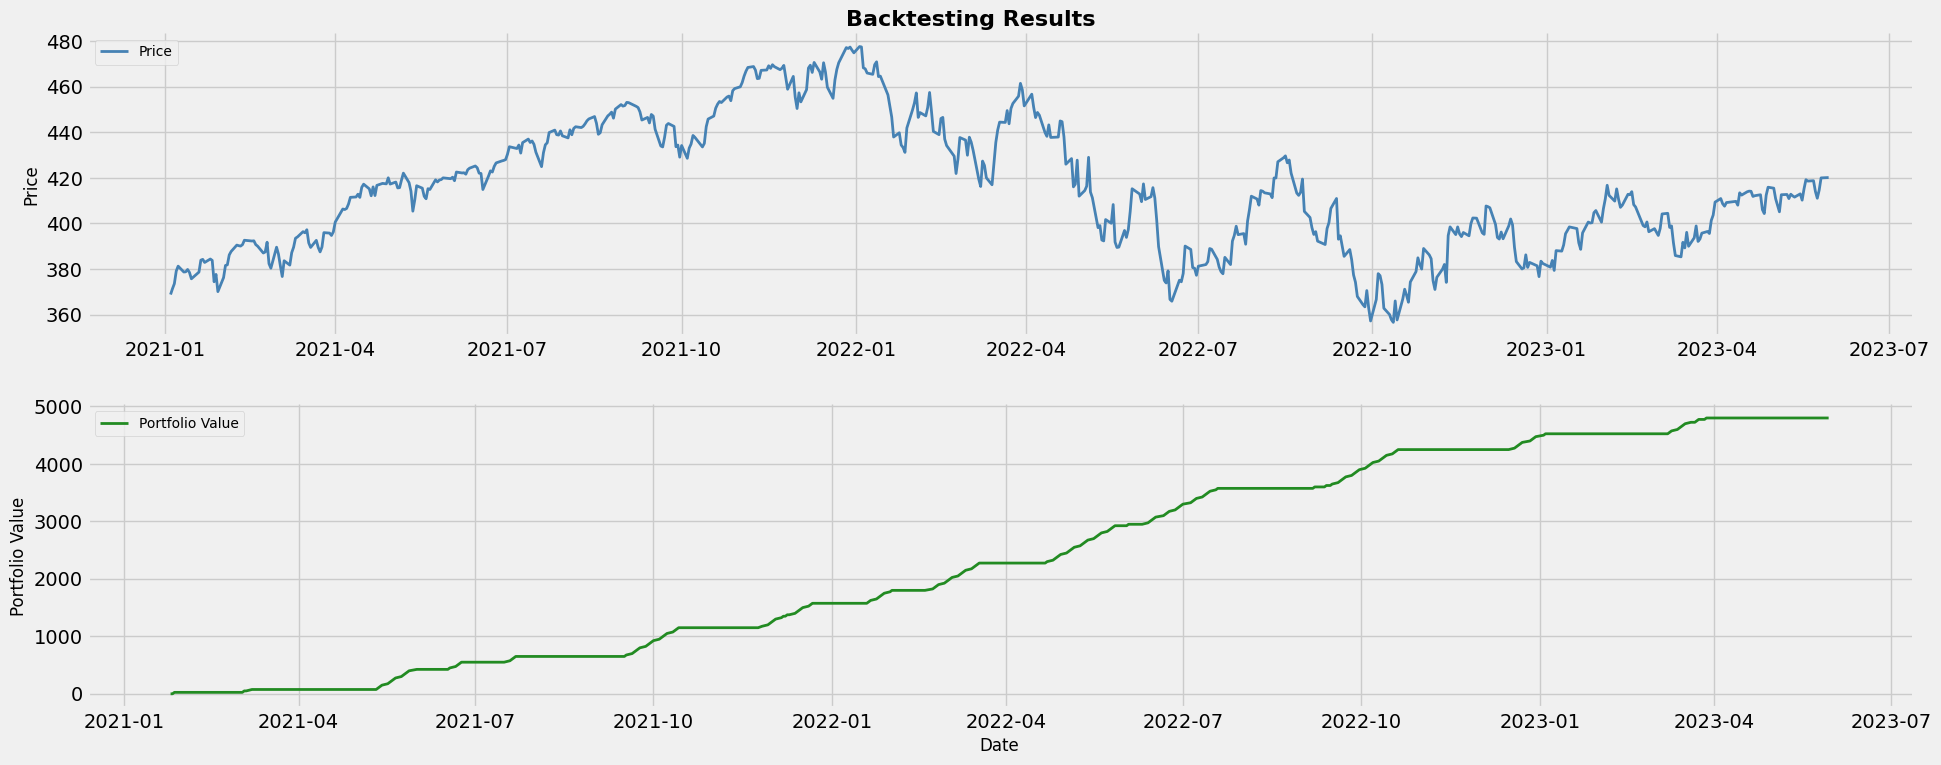

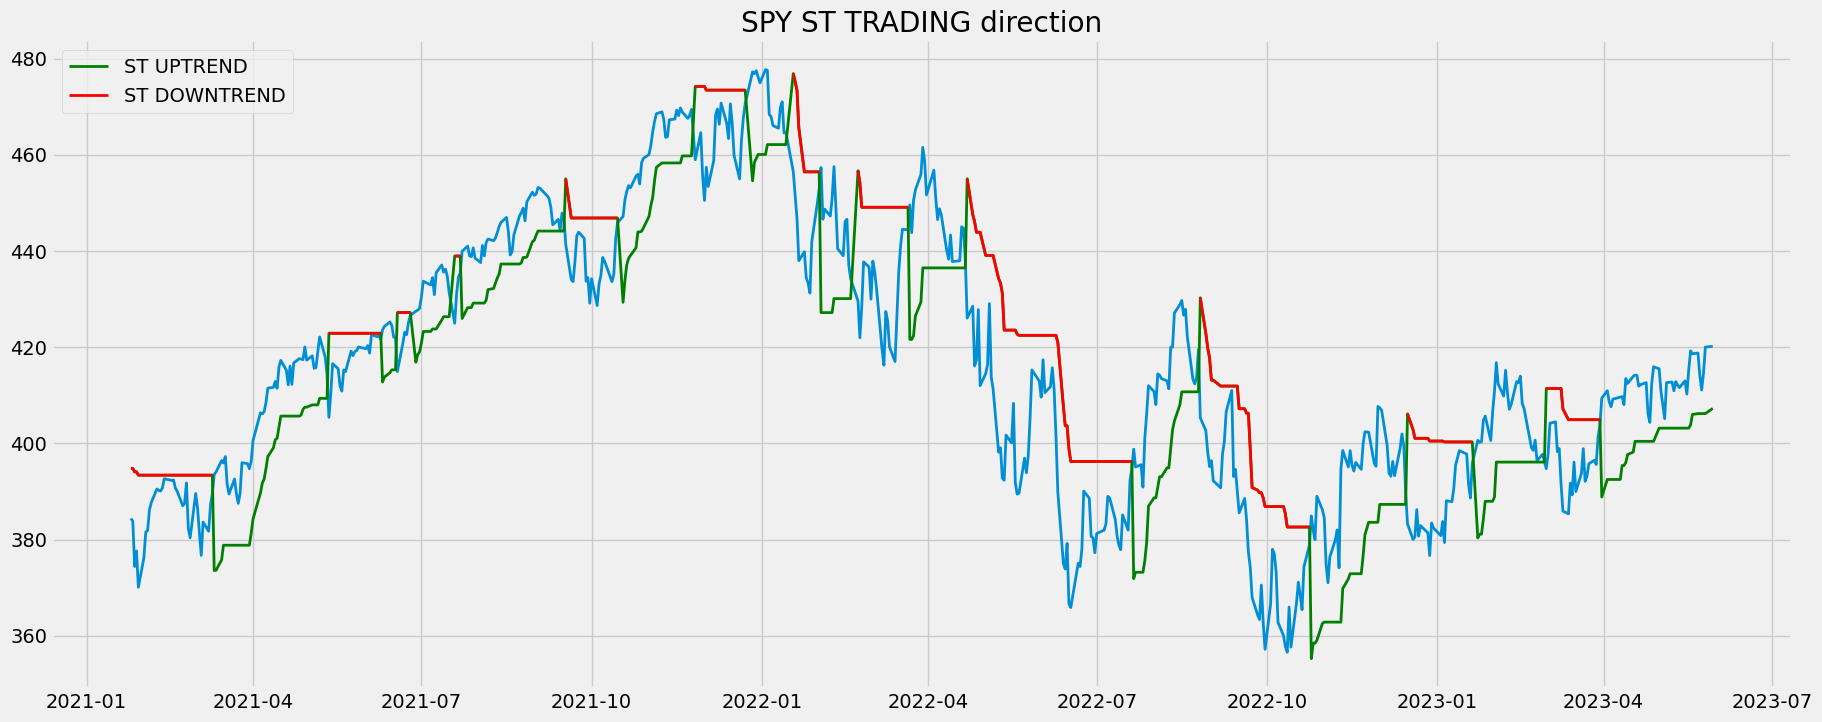

In [45]:
# Initiate Backtesting and Load Data
backtester = BacktestingSystem(investment_cash=25)
backtester.load_data('SPY', '2021-01-01', '2023-05-31')

# Inporting the fear and greed data
Fear_data = pd.read_csv(r'C:\Users\vamsh\OneDrive\Desktop\Trading_Bot_version_1\Data\complete_data_fearindex.csv',index_col=0)
Fear_data.columns = ['Date','Fear_index']
Fear_data['Date'] = pd.to_datetime(Fear_data['Date'])     

# # Usage Example for Moving Average strategy
moving_average_strategy = FearandGreedIndexStrategy(backtester.data,Fear_data)
moving_average_portfolio = backtester.backtest_strategy(moving_average_strategy)
backtester.plot_results(moving_average_portfolio)
backtester.plot_indicator(moving_average_strategy.generate_signals())

In [68]:
moving_average_strategy.generate_signals()['Fear_index']

,Fear_index,open,high,low,close,volume,signal,st,s_upt,st_dt
Date,,,,,,,,,,
2021-01-25,69.700000,383.670013,384.769989,378.459991,384.390015,70402000,0,394.802141,NaN,394.802141
2021-01-26,67.400000,385.410004,385.850006,383.540009,383.790009,42665300,0,394.802141,NaN,394.802141
2021-01-27,28.200000,380.220001,380.320007,372.010010,374.410004,123351100,1,394.074046,NaN,394.074046
2021-01-28,52.900000,376.359985,381.929993,375.890015,377.630005,94198100,0,394.074046,NaN,394.074046
2021-01-29,40.966667,375.630005,376.670013,368.269989,370.070007,126765100,0,393.384626,NaN,393.384626
...,...,...,...,...,...,...,...,...,...,...
2023-05-23,65.085714,417.079987,418.720001,413.679993,414.089996,86383500,0,406.193023,406.193023,NaN
2023-05-24,59.057143,412.420013,412.820007,409.880005,411.089996,89213700,0,406.193023,406.193023,NaN
2023-05-25,62.514286,414.739990,416.160004,412.410004,414.649994,90961600,0,406.193023,406.193023,NaN


In [48]:
def calculate_rsi(data, period=14):
    close_prices = data['Fear_index']
    price_changes = close_prices.diff()

    gains = price_changes.mask(price_changes < 0, 0)
    losses = -price_changes.mask(price_changes > 0, 0)

    average_gain = gains.rolling(window=period).mean()
    average_loss = losses.rolling(window=period).mean()

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

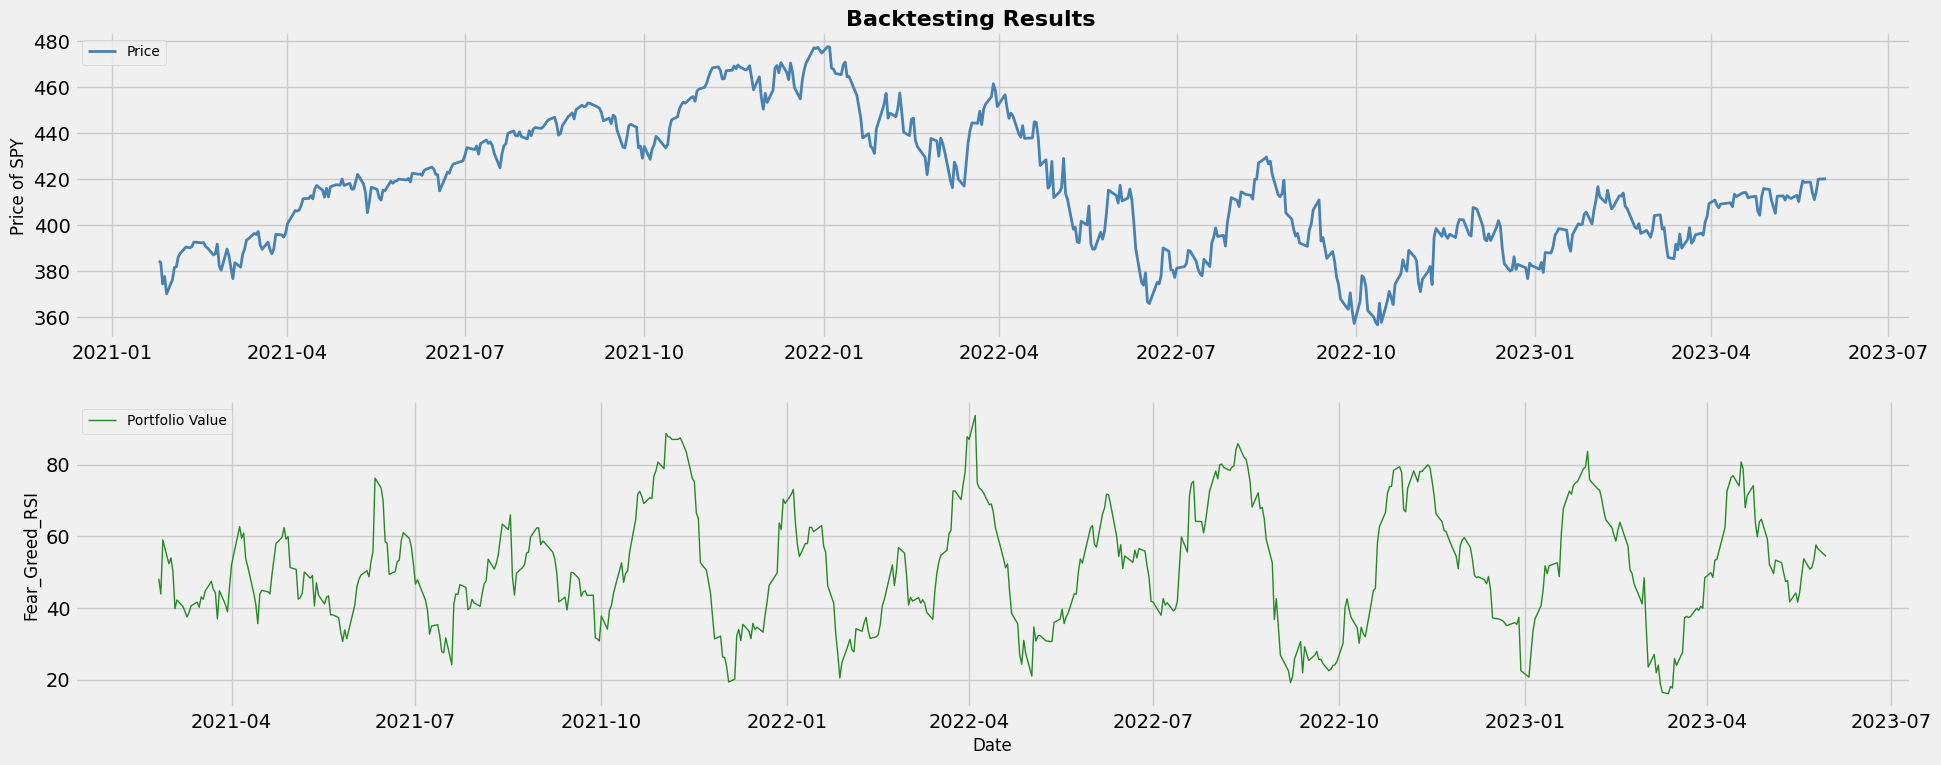

In [76]:
plt.style.use('fivethirtyeight')

    
fig, ax = plt.subplots(2, 1, figsize=(20, 8))

# Plot stock price
ax[0].plot(moving_average_strategy.generate_signals()['close'], label='Price', color='steelblue', linewidth=2)
ax[0].set_ylabel('Price of SPY', fontsize=12)
ax[0].legend(loc='upper left', fontsize=10)

# Plot portfolio value
ax[1].plot(calculate_rsi(moving_average_strategy.generate_signals(), period=21), label='Portfolio Value', color='forestgreen', linewidth=1)
ax[1].set_ylabel('Fear_Greed_RSI', fontsize=12)
ax[1].legend(loc='upper left', fontsize=10)

# Set x-axis label for the last subplot
ax[1].set_xlabel('Date', fontsize=12)

# Adjust spacing between subplots
plt.tight_layout(pad=2)

# Set title and axis labels
fig.suptitle('Backtesting Results', fontsize=16, fontweight='bold')

# Customize tick parameters
plt.tick_params(axis='both', which='both', bottom=False, left=False)

# Remove spines
for axis in ['top', 'right']:
    ax[0].spines[axis].set_visible(False)
    ax[1].spines[axis].set_visible(False)

# Display the plot
plt.show()